In [1]:
import pickle
from predictor_all import AudioPredictor
from predictor_all import VoteClassifier
from predictor_all import ImagePredictor
from keras.models import load_model
import speech_recognition as sr
from collections import Counter
import cv2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import matplotlib.image as mpimg
from pydub import AudioSegment, effects
import os

import threading
import speech_recognition as sr
from collections import Counter
from keras.preprocessing import image
import librosa
from moviepy.editor import VideoFileClip
import tempfile
import os
from queue import Queue
from keras.preprocessing import sequence
from keras.preprocessing import image
import warnings

C:\Users\ssttg\anaconda3\Lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [2]:
# Load the pre-trained models
with open('audio_classifier_model.pkl', 'rb') as f:
    audio_classifier = pickle.load(f)

with open('text_classifier_model.pkl', 'rb') as f:
    text_classifier = pickle.load(f)

with open('image_predictor.pkl', 'rb') as f:
    image_predictor = pickle.load(f)

In [3]:
# Emotion Labels for different models
emotion_labels_img = ["Anger", "Disgust", "Fear", "Happiness", "Sadness", "Surprise"]
emotion_labels_audio = ["Happiness", "Neutral", "Sadness", "Anger", "Fear", "Disgust"]
emotion_labels_text = ["Anger", "Disgust", "Fear", "Happiness", "Sadness", "Surprise", "Neutral"]


In [4]:
# Function to extract text from audio using SpeechRecognition
def extract_text_from_audio(audio_file):
    recognizer = sr.Recognizer()
    with sr.AudioFile(audio_file) as source:
        audio_data = recognizer.record(source)
    try:
        text = recognizer.recognize_google(audio_data)
        return text
    except (sr.UnknownValueError, sr.RequestError) as e:
        print(f"Error in audio text extraction: {e}")
        return None

In [18]:
class MultiModalSentimentAnalysis:
    def __init__(self, audio_model, text_model, image_model):
        self.audio_model = audio_model
        self.text_model = text_model
        self.image_model = image_model

    def predict(self, text=None, image_path=None, audio_path=None):
        predictions = []

        # Predict from text if provided
        if text is not None:
            try:
                text_prediction = self.text_model.text_classify(text)
                text_emotion = emotion_labels_text[int(text_prediction)]
                predictions.append(text_emotion)
                print(f"Predicted emotion from text: {text_emotion}")
            except Exception as e:
                print(f"Error in text prediction: {e}")
        
        # Predict from image if provided
        if image_path is not None:
            try:
                image_prediction = self.image_model.image_classify(image_path)
                image_emotion = emotion_labels_img[int(image_prediction)]
                predictions.append(image_emotion)
                print(f"Predicted emotion from image: {image_emotion}")
            except Exception as e:
                print(f"Error in image prediction: {e}")
        
        # Predict from audio if provided
        if audio_path is not None:
            try:
                audio_prediction = self.audio_model.audio_classify(audio_path)
                audio_emotion = emotion_labels_audio[int(audio_prediction)]
                predictions.append(audio_emotion)
                print(f"Predicted emotion from audio: {audio_emotion}")
            except Exception as e:
                print(f"Error in audio prediction: {e}")
        
        # If all predictions are different, prioritize the image prediction
        if len(predictions) == 3 and len(set(predictions)) == 3:  # All predictions are different
            print(f"Different emotions predicted from all models. Prioritizing audio prediction.")
            return predictions[2]  # Image prediction is in the second position (index 1)
        
        # Majority voting logic if predictions are the same or not all different
        if len(predictions) > 0:
            most_common_emotion = max(set(predictions), key=predictions.count)
            print(f"Final predicted emotion: {most_common_emotion}")
            return most_common_emotion
        else:
            print("No data provided for prediction.")
            return None

    def process_video(self, video_path):
        # Extract audio from video
        video = VideoFileClip(video_path)
        audio_path = "temp_audio.wav"
        video.audio.write_audiofile(audio_path)
        
        # Extract frames from video
        cap = cv2.VideoCapture(video_path)
        frame_count = 0
        image_path = None
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            frame_count += 1
            # Save only the first frame as an image for simplicity
            if frame_count == 1:
                image_path = "temp_image.jpg"
                cv2.imwrite(image_path, frame)
                break
        cap.release()

        # Predict sentiment using the extracted audio, text, and image
        text_input = extract_text_from_audio(audio_path)  # Extract text from the audio
        final_emotion = self.predict(text=text_input, image_path=image_path, audio_path=audio_path)

        # Clean up temporary files
        if os.path.exists(audio_path):
            os.remove(audio_path)
        if image_path and os.path.exists(image_path):
            os.remove(image_path)

        return final_emotion

# Instantiate the multi-modal sentiment analysis model
multi_modal_model = MultiModalSentimentAnalysis(
    audio_model=audio_classifier,
    text_model=text_classifier,
    image_model=image_predictor
)

In [20]:
# Example usage:

# Test with a video input
video_input_path = "./Sad.mp4"  # Replace with your video file path
final_prediction = multi_modal_model.process_video(video_input_path)

# Check if the final prediction contains two different emotions
if isinstance(final_prediction, list):
    print(f"Final predicted emotions from image, audio, and text: {final_prediction}")
else:
    print(f"Final predicted emotion from video: {final_prediction}")

MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted emotion from text: Neutral
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
Predicted emotion from image: Disgust
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Predicted emotion from audio: Sadness
Different emotions predicted from all models. Prioritizing audio prediction.
Final predicted emotion from video: Sadness


In [22]:
text_data = pd.read_csv('./Text-based-Multimodel/TEST_DATA.csv')

In [28]:
text_data = text_data.head(500)

In [30]:
text_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  500 non-null    object
 1   Emotion   500 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 7.9+ KB


In [32]:
text_data.head(10)

,Sentence,Emotion
0,I’m really sorry about your situation :( Altho...,4
1,It's wonderful because it's awful. At not with.,3
2,"Kings fan here, good luck to you guys! Will be...",3
3,"I didn't know that, thank you for teaching me ...",3
4,They got bored from haunting earth for thousan...,6
5,Thank you for asking questions and recognizing...,3
6,You’re welcome,3
7,100%! Congrats on your job too!,3
8,I’m sorry to hear that friend :(. It’s for the...,4
9,"Girlfriend weak as well, that jump was pathetic.",4


In [115]:
predictions = []

for index, row in text_data.iterrows():
    text = row['Sentence']
    
    try:
        # Make prediction using the model (assuming the model has a method text_classify())
        text_prediction = text_classifier.text_classify(text)

        # Convert the model output to an emotion label
        text_emotion = emotion_labels_text[int(text_prediction)]
        
        # Append the predicted emotion to the predictions list
        predictions.append(text_emotion)
    
    except Exception as e:
        print(f"Error predicting for sentence: '{text}'. Skipping. Error: {e}")
        predictions.append(None)  # Append None or any placeholder if prediction fails

true_labels = text_data['Emotion'].apply(lambda x: emotion_labels_text[x]).values

# Calculate the accuracy, ignoring any None (failed) predictions
valid_predictions = [pred for pred in predictions if pred is not None]
valid_true_labels = [true for pred, true in zip(predictions, true_labels) if pred is not None]

# Calculate the accuracy
correct_predictions = sum([1 for pred, true in zip(valid_predictions, valid_true_labels) if pred == true])
text_accuracy = correct_predictions / len(valid_true_labels)  # Total number of valid samples in the dataframe

print(f"Accuracy: {text_accuracy * 100:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Error predicting for sentence: 'Well, there's cubs and otters too.'. Skipping. Error: {{function_node __wrapped__IteratorGetNext_output_types_1_device_/job:localhost/replic

In [3]:
text_accuracy = 0.6857885010266941

In [5]:
text_accuracy

0.6857885010266941

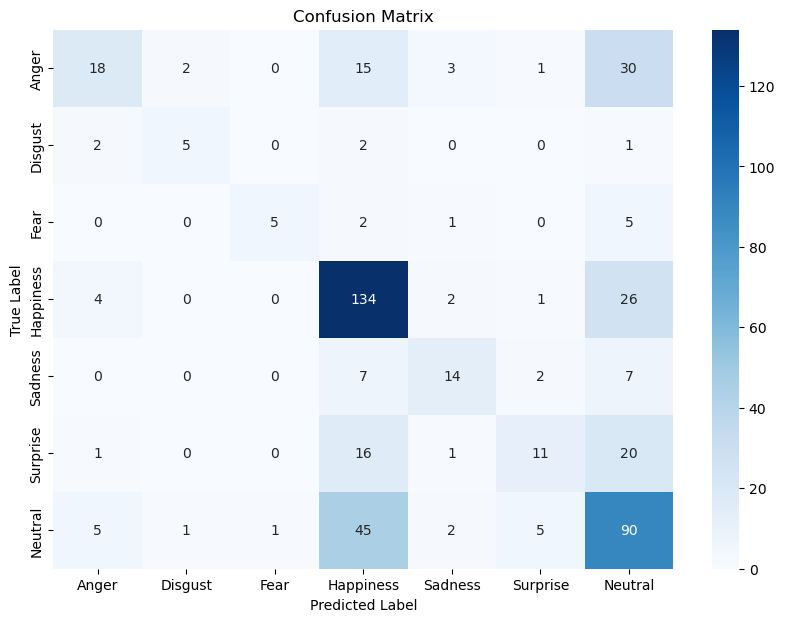

In [365]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Create confusion matrix
conf_matrix = confusion_matrix(valid_true_labels, valid_predictions, labels=emotion_labels_text)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels_text, yticklabels=emotion_labels_text)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# Audio

In [35]:
audio_file_path = 'TESS Toronto emotional speech set data\\OAF_angry\\OAF_bath_angry.wav'

In [41]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

def plot_spectrogram(audio_file, save_path=None):
    # Load the audio file
    y, sr = librosa.load(audio_file, sr=None)

    # Generate the Short-Time Fourier Transform (STFT)
    S = librosa.stft(y)
    S_db = librosa.amplitude_to_db(abs(S), ref=np.max)

    # Plot the spectrogram
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')

    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"Spectrogram saved at {save_path}")
    else:
        plt.show()


Spectrogram saved at spectrogram.png


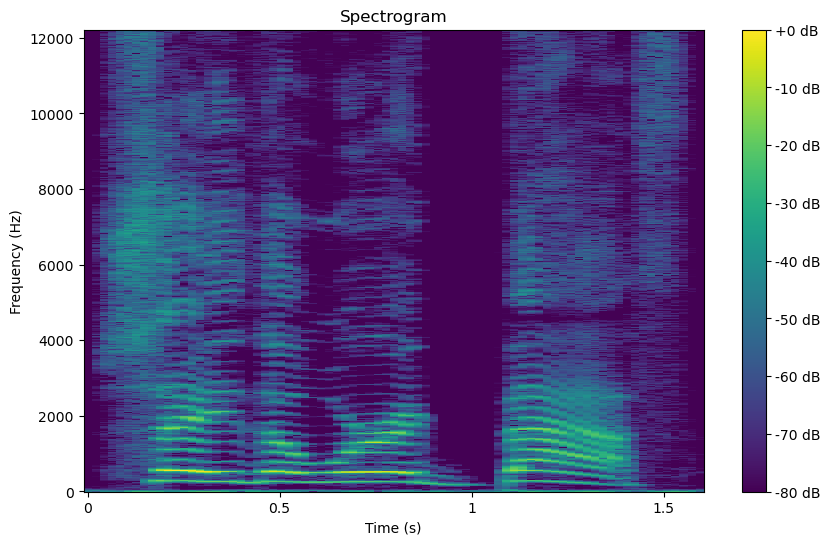

In [43]:
audio_path = './AUDIO/TESS Toronto emotional speech set data\\OAF_angry\\OAF_bath_angry.wav'
output_path = 'spectrogram.png' 
plot_spectrogram(audio_path, save_path=output_path)

Spectrogram saved at spectrogram.png


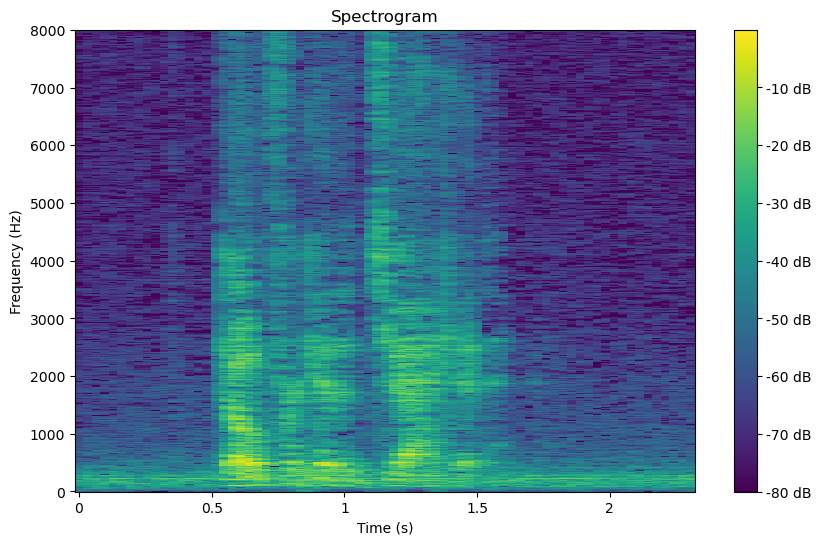

In [45]:
audio_path = './AUDIO/AudioWAV/1001_DFA_DIS_XX.wav'
output_path = 'spectrogram.png' 
plot_spectrogram(audio_path, save_path=output_path)

Spectrogram saved at spectrogram.png


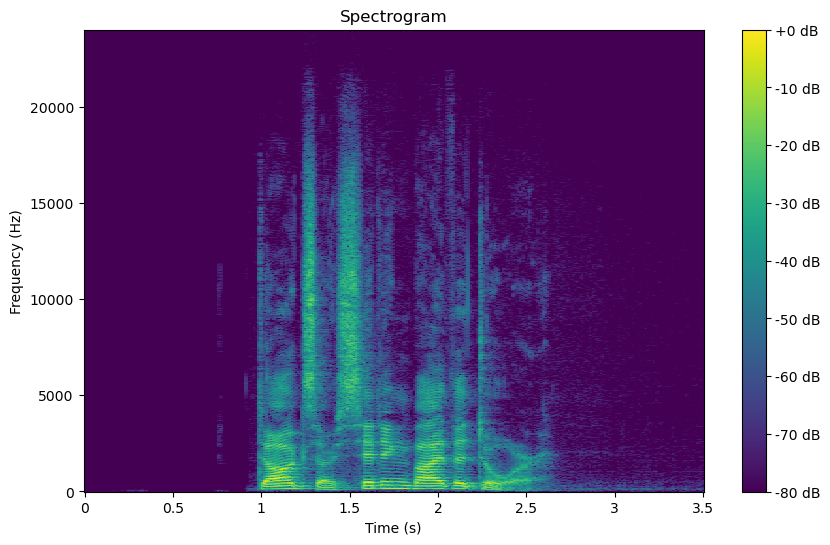

In [47]:
audio_path = './AUDIO/audio_speech_actors_01-24/Actor_03/03-01-01-01-02-01-03.wav'
output_path = 'spectrogram.png' 
plot_spectrogram(audio_path, save_path=output_path)

In [201]:
from keras.models import load_model
audio_model = load_model('audio.h5')

In [205]:
audio_data = pd.read_csv('./AUDIO/DATA.csv')
audio_data['path'] = audio_data['path'].apply(lambda x: os.path.normpath(f"./AUDIO/{x}"))

In [207]:
audio_data.head()

,path,emotion
0,AUDIO\audio_speech_actors_01-24\Actor_02\03-01...,neutral
1,AUDIO\audio_speech_actors_01-24\Actor_02\03-01...,neutral
2,AUDIO\audio_speech_actors_01-24\Actor_02\03-01...,neutral
3,AUDIO\audio_speech_actors_01-24\Actor_02\03-01...,neutral
4,AUDIO\audio_speech_actors_01-24\Actor_02\03-01...,happy


In [209]:
def create_waveplot(y, sr, title):
    plt.figure(figsize=(8, 2))
    plt.title(title)
    librosa.display.waveshow(y, sr=sr)
    plt.show()

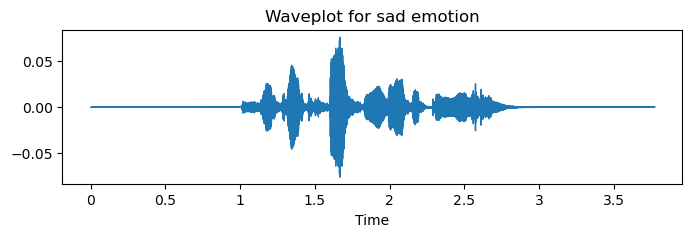

In [211]:
emotion_label = 'sad'
title = f"Waveplot for {emotion_label} emotion"
path = np.array(audio_data.path[audio_data.emotion == emotion_label])[1]
y, sr = librosa.load(path)

create_waveplot(y, sr, title)

In [213]:
def preprocess_audio(path):
    _, sr = librosa.load(path)
    raw_audio = AudioSegment.from_file(path)
    
    samples = np.array(raw_audio.get_array_of_samples(), dtype='float32')
    trimmed, _ = librosa.effects.trim(samples, top_db=25)
    padded = np.pad(trimmed, (0, 180000-len(trimmed)), 'constant')
    return padded, sr

emotion_dic = {
    'neutral' : 0,
    'happy'   : 1,
    'sad'     : 2, 
    'angry'   : 3, 
    'fear'    : 4, 
    'disgust' : 5
}

def encode(label):
    return emotion_dic.get(label)

In [219]:
zcr_list = []
rms_list = []
mfccs_list = []
emotion_list = []

FRAME_LENGTH = 2048
HOP_LENGTH = 512

for row in audio_data.itertuples(index=False):
    try: 
        y, sr = preprocess_audio(row.path)

        zcr = librosa.feature.zero_crossing_rate(y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
        rms = librosa.feature.rms(y=y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, hop_length=HOP_LENGTH)

        zcr_list.append(zcr)
        rms_list.append(rms)
        mfccs_list.append(mfccs)

        emotion_list.append(encode(row.emotion))
    except:
        print(f"Failed for path: {row.path}")

Failed for path: AUDIO\audio_speech_actors_01-24\Actor_20\03-01-06-01-01-02-20.wav


  warn("Couldn't find ffprobe or avprobe - defaulting to ffprobe, but may not work", RuntimeWarning)



Failed for path: AUDIO\TESS Toronto emotional speech set data\YAF_angry\YAF_germ_angry.wav
Failed for path: AUDIO\TESS Toronto emotional speech set data\YAF_fear\YAF_neat_fear.wav


In [227]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
X = np.concatenate((
    np.swapaxes(zcr_list, 1, 2), 
    np.swapaxes(rms_list, 1, 2), 
    np.swapaxes(mfccs_list, 1, 2)), 
    axis=2
)
X = X.astype('float32')

y = np.asarray(emotion_list)
y = np.expand_dims(y, axis=1).astype('int8')

X_train, X_to_split, y_train, y_to_split = train_test_split(X, y, test_size=0.12, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_to_split, y_to_split, test_size=0.3, random_state=1)

y_train_class = to_categorical(y_train, 6)
y_val_class = to_categorical(y_val, 6)

In [229]:
print(audio_model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 352, 64)             │          20,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 53,896 (210.54 KB)

 Trainable params: 53,894 (210.52 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None


In [231]:
test_loss_audio, test_accuracy_audio = audio_model.evaluate(X_val, y_val_class, verbose=0)

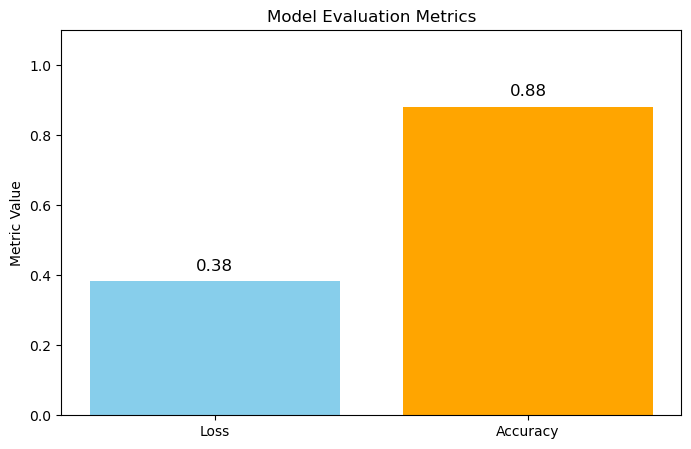

In [241]:
import matplotlib.pyplot as plt

evaluation_metrics = {
    "Loss": test_loss_audio,
    "Accuracy": test_accuracy_audio
}

metrics = list(evaluation_metrics.keys())
values = list(evaluation_metrics.values())

# Plot evaluation metrics
plt.figure(figsize=(8, 5))
plt.bar(metrics, values, color=['skyblue', 'orange'])
plt.ylim(0, 1.1)  # Ensure the y-axis accommodates accuracy and loss
plt.ylabel('Metric Value')
plt.title('Model Evaluation Metrics')
for i, v in enumerate(values):
    plt.text(i, v + 0.03, f"{v:.2f}", ha='center', fontsize=12)

plt.show()


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step


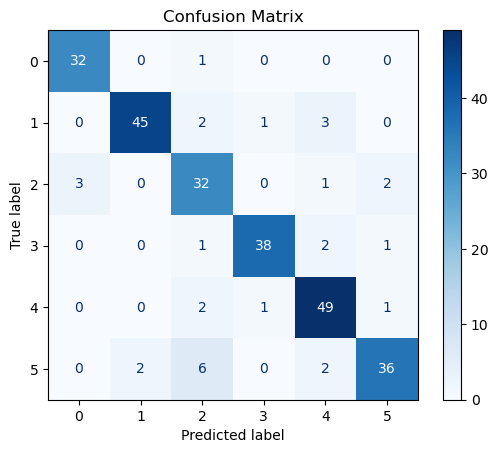

In [247]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate predictions
y_pred = np.argmax(audio_model.predict(X_val), axis=1)
y_true = np.argmax(y_val_class, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(y_val_class.shape[1]))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


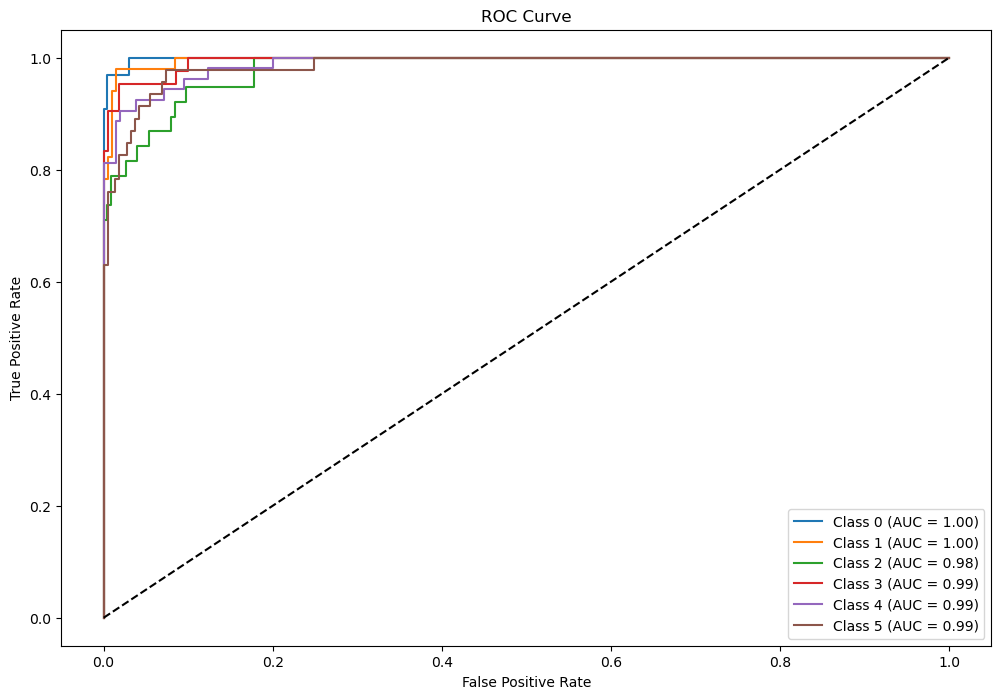

In [249]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize labels for ROC calculation
y_true_binary = label_binarize(y_true, classes=range(y_val_class.shape[1]))

# Compute ROC curve and AUC for each class
plt.figure(figsize=(12, 8))
for i in range(y_val_class.shape[1]):
    fpr, tpr, _ = roc_curve(y_true_binary[:, i], audio_model.predict(X_val)[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()


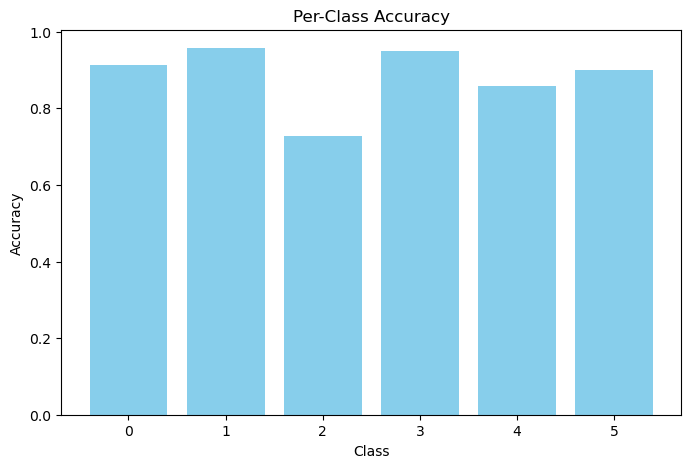

In [251]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(y_true, y_pred, output_dict=True)

# Extract class-wise accuracy
class_accuracies = {k: v['precision'] for k, v in report.items() if k.isdigit()}

# Plot class accuracies
plt.figure(figsize=(8, 5))
plt.bar(class_accuracies.keys(), class_accuracies.values(), color='skyblue')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Per-Class Accuracy')
plt.show()


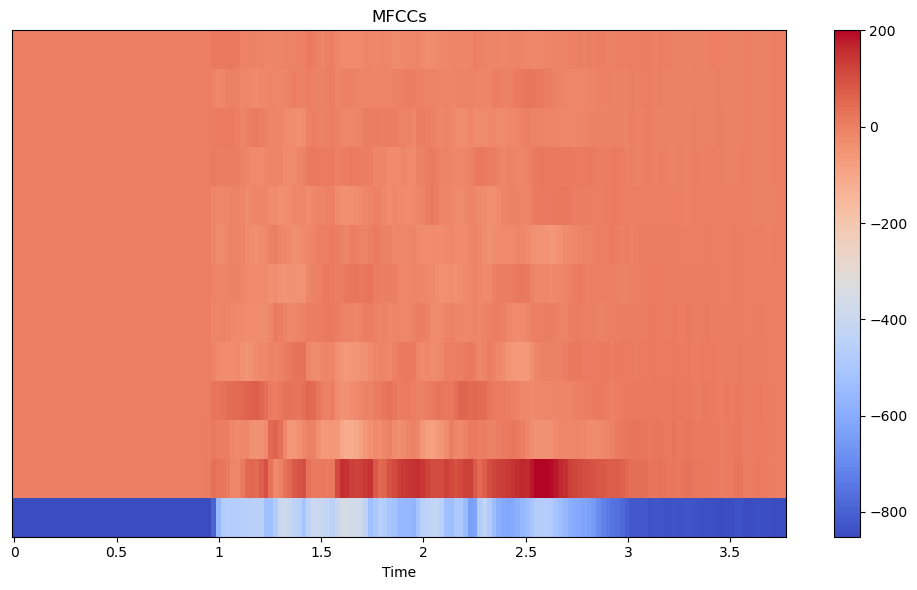

In [255]:
import librosa.display

# Extract an example audio file's features
y, sr = librosa.load(np.array(audio_data.path[audio_data.emotion == emotion_label])[1])
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

# Plot MFCCs
plt.figure(figsize=(10, 6))
librosa.display.specshow(mfccs, x_axis='time', sr=sr, cmap='coolwarm')
plt.colorbar()
plt.title('MFCCs')
plt.tight_layout()
plt.show()


# Image

In [58]:
image_path = './Image/6 Emotions for image classification/anger.jpg/g3ry3pkr1npzzhoetl.jpg'

In [72]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def display_image(image_path):

    img = mpimg.imread(image_path)

    plt.figure(figsize=(8, 8)) 
    plt.imshow(img)
    plt.axis('off') 
    plt.title('Image Display', fontsize=16)
    plt.show()

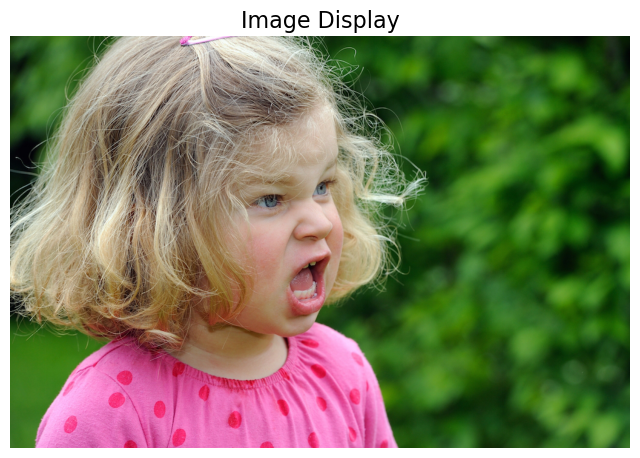

In [74]:
image_path = './Image/6 Emotions for image classification/anger.jpg/g3ry3pkr1npzzhoetl.jpg'
display_image(image_path)

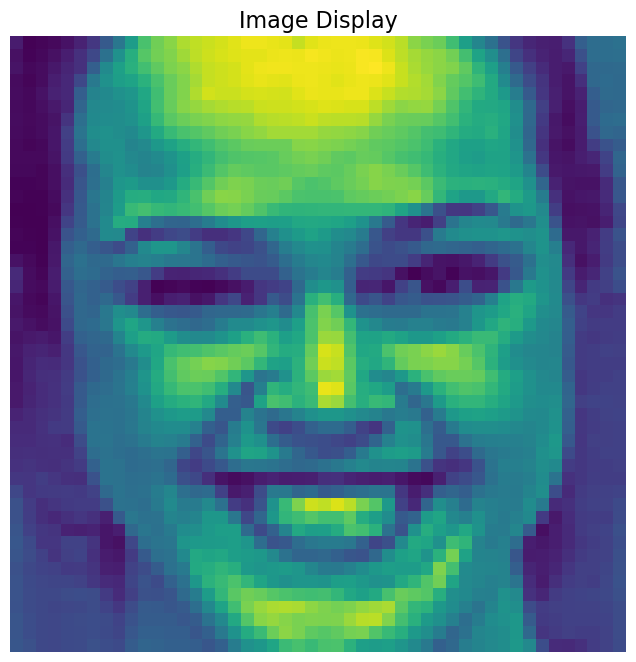

In [76]:
image_path = './Image/CK/ck/CK+48/happy/S026_006_00000013.png'
display_image(image_path)

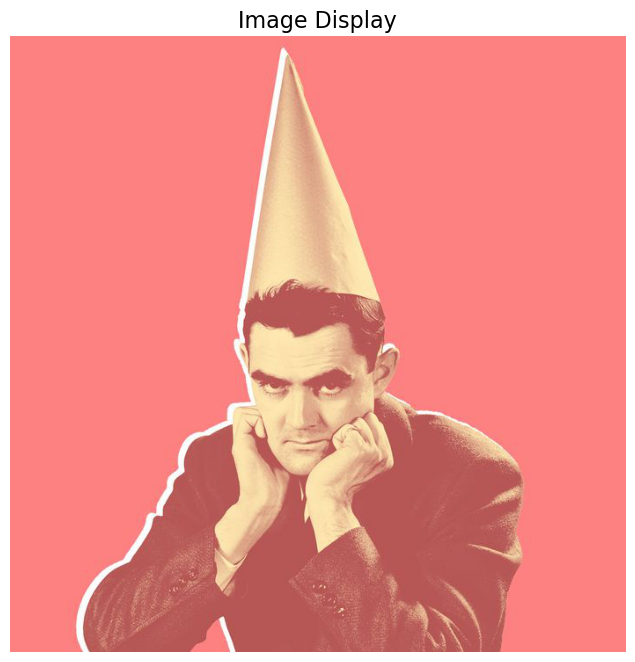

In [88]:
image_path = './Image/data/Angry/0346f330983a068db0633f96d4a13de873-06-angry.rsquare.w700.jpg'
display_image(image_path)

In [317]:
path = "./Image/6 Emotions for image classification"
classes = sorted(os.listdir(path))

anger_path = "./Image/6 Emotions for image classification/anger.jpg"
disgust_path = "./Image/6 Emotions for image classification/disgust.jpg"
fear_path = "./Image/6 Emotions for image classification/fear.jpg"
happy_path = "./Image/6 Emotions for image classification/happy.jpg"
pain_path = "./Image/6 Emotions for image classification/pain.jpg"
sad_path = "./Image/6 Emotions for image classification/sad.jpg"

In [319]:
def dataset_statistics(folder_path):
    class_counts = {}
    for root, dirs, files in os.walk(folder_path):
        if files:
            class_name = os.path.basename(root)
            class_counts[class_name] = len(files)
    return class_counts

input_folder = [anger_path, fear_path, disgust_path, happy_path, pain_path, sad_path]
print("Dataset Statistics:")
for input in input_folder:
  dataset_stats = dataset_statistics(input)
  for class_name, count in dataset_stats.items():
      print(f"{class_name}: {count} images")

Dataset Statistics:
anger.jpg: 214 images
.ipynb_checkpoints: 7 images
fear.jpg: 163 images
disgust.jpg: 195 images
happy.jpg: 230 images
.ipynb_checkpoints: 2 images
pain.jpg: 168 images
sad.jpg: 224 images


In [321]:
for filename in os.listdir(path):
    if (filename.endswith(ext) for ext in ['.jpeg', '.png', '.gif']):
        prefix = os.path.splitext(filename)[0]
        os.rename(os.path.join(path, filename), os.path.join(path, prefix+'.jpg'))
    else:
        continue

def to_frame(path):
    class_types = []
    class_paths = []
    files = os.listdir(path)
    for file in files:
        label_dir = os.path.join(path, file)
        label = os.listdir(label_dir)
        for image in label:
            image_path = os.path.join(label_dir, image)
            class_paths.append(image_path)
            class_name = os.path.splitext(file)[0]
            class_types.append(class_name)
    image_classes = pd.Series(class_types, name='Class')
    image_paths = pd.Series(class_paths, name='Class Path')
    df = pd.concat([image_paths, image_classes], axis=1)
    return df

image_data = to_frame(path)

In [323]:
image_data.head()

,Class Path,Class
0,./Image/6 Emotions for image classification\an...,anger
1,./Image/6 Emotions for image classification\an...,anger
2,./Image/6 Emotions for image classification\an...,anger
3,./Image/6 Emotions for image classification\an...,anger
4,./Image/6 Emotions for image classification\an...,anger


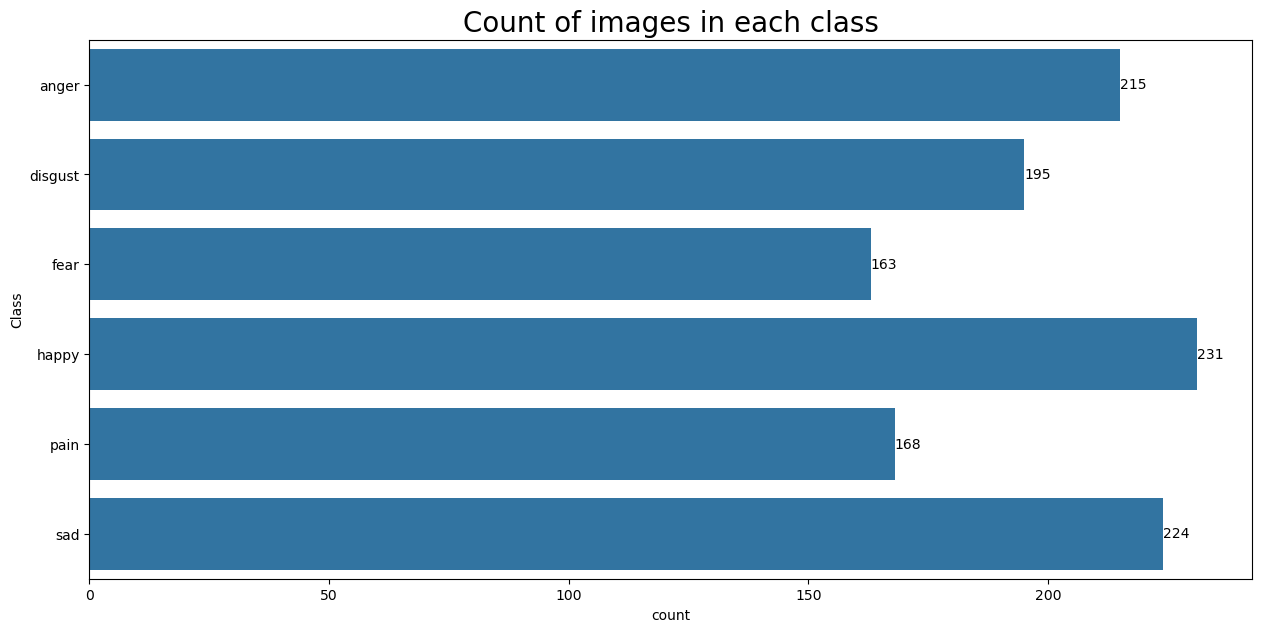

In [325]:
import seaborn as sns
plt.figure(figsize=(15,7))
ax = sns.countplot(data=image_data , y=image_data['Class'])
plt.title('Count of images in each class', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

In [327]:
train_df, test_df = train_test_split(image_data,  train_size= 0.7, shuffle= True, random_state= 20)
valid_df, test_df = train_test_split(test_df,  train_size= 0.5, shuffle= True, random_state= 20)


In [329]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set parameters
batch_size = 32
img_size = (299, 299)

# Define data augmentation for training
train_gen = ImageDataGenerator(
    rescale=1.0/255,  # Correct scaling value
    brightness_range=(0.8, 1.2),
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Define rescaling for validation and testing
valid_test_datagen = ImageDataGenerator(rescale=1.0/255)  # Correct scaling value

# Create training generator
train_gen = train_gen.flow_from_dataframe(
    dataframe=train_df,  # Ensure 'train_df' is defined
    x_col='Class Path',
    y_col='Class',
    target_size=img_size,
    color_mode='rgb',  # Default is 'rgb', optional to keep
    class_mode='categorical',  # Specify class_mode for multi-class
    batch_size=batch_size,
    shuffle=True
)

# Create validation generator
valid_gen = valid_test_datagen.flow_from_dataframe(
    dataframe=valid_df,  # Ensure 'valid_df' is defined
    x_col='Class Path',
    y_col='Class',
    target_size=img_size,
    color_mode='rgb',  # Default is 'rgb', optional to keep
    class_mode='categorical',  # Specify class_mode for multi-class
    batch_size=batch_size,
    shuffle=True
)

# Create test generator
test_gen = valid_test_datagen.flow_from_dataframe(
    dataframe=test_df,  # Ensure 'test_df' is defined
    x_col='Class Path',
    y_col='Class',
    target_size=img_size,
    color_mode='rgb',  # Default is 'rgb', optional to keep
    class_mode='categorical',  # Specify class_mode for multi-class
    batch_size=batch_size,
    shuffle=False  # Ensure shuffle is False for test data
)


  warnings.warn(



Found 807 validated image filenames belonging to 6 classes.


  warnings.warn(



Found 170 validated image filenames belonging to 6 classes.


  warnings.warn(



Found 169 validated image filenames belonging to 6 classes.


In [331]:
image_model = load_model('Image_model_67.h5')

In [332]:
image_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 2048)                │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,977,008 (83.84 MB)

 Trainable params: 21,922,478 (83.63 MB)

 Non-trainable params: 54,528 (213.00 KB)

 Optimizer params: 2 (12.00 B)

In [337]:
# Evaluate the model on the test data
test_loss_image, test_accuracy_image, test_precision_image, test_recall_image = image_model.evaluate(
    test_gen, 
    steps=len(test_gen)
)

# Print the evaluation results
print(f"Test Loss: {test_loss_image:.4f}")
print(f"Test Accuracy: {test_accuracy_image:.4f}")
print(f"Test Precision: {test_precision_image:.4f}")
print(f"Test Recall: {test_recall_image:.4f}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.8600 - loss: 0.6210 - precision_2: 0.8590 - recall_2: 0.8526
Test Loss: 0.7028
Test Accuracy: 0.8521
Test Precision: 0.8512
Test Recall: 0.8462



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=values, palette='Blues')



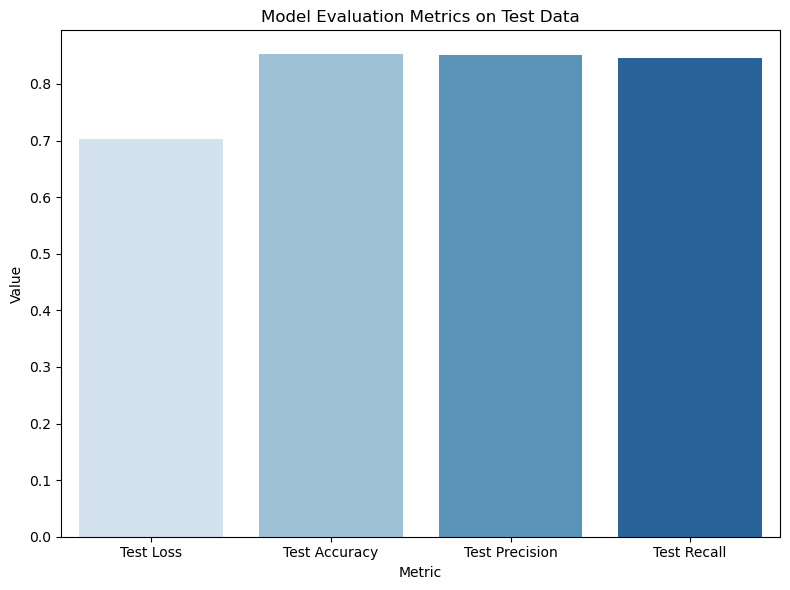

In [341]:
import matplotlib.pyplot as plt
import seaborn as sns

# Data for plotting
metrics = ['Test Loss', 'Test Accuracy', 'Test Precision', 'Test Recall']
values = [test_loss_image, test_accuracy_image, test_precision_image, test_recall_image]

# Create a bar plot for these metrics
plt.figure(figsize=(8, 6))
sns.barplot(x=metrics, y=values, palette='Blues')
plt.title('Model Evaluation Metrics on Test Data')
plt.ylabel('Value')
plt.xlabel('Metric')
plt.tight_layout()
plt.show()


6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step


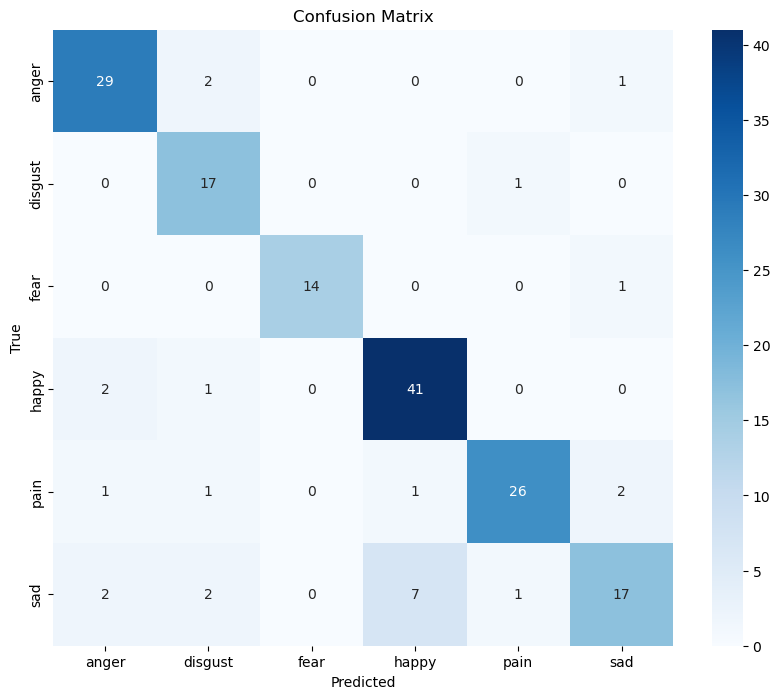

In [343]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Assuming you have the test labels (y_test) and predicted labels (y_pred)
y_pred = image_model.predict(test_gen, steps=len(test_gen))
y_pred_classes = np.argmax(y_pred, axis=1)  # Assuming a classification task

# If you have the true labels as one-hot encoded (y_test), convert them to labels
y_true = test_gen.classes  # Or use np.argmax(y_test, axis=1) if you have one-hot encoded labels

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_gen.class_indices.keys(), yticklabels=test_gen.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


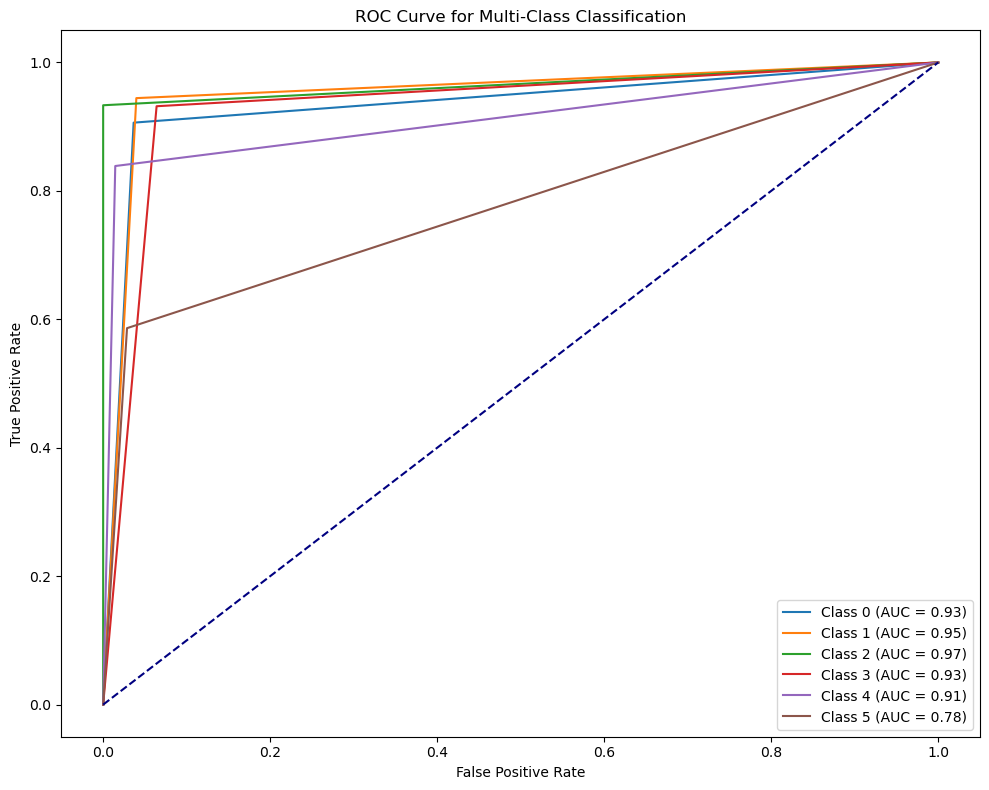

In [349]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the labels for multi-class ROC
y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3, 4, 5])  # Adjust based on the number of classes
y_pred_bin = label_binarize(np.argmax(y_pred, axis=1), classes=[0, 1, 2, 3, 4, 5])

# Compute ROC curve and ROC AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(6):  # 6 classes
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(6):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title('ROC Curve for Multi-Class Classification')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


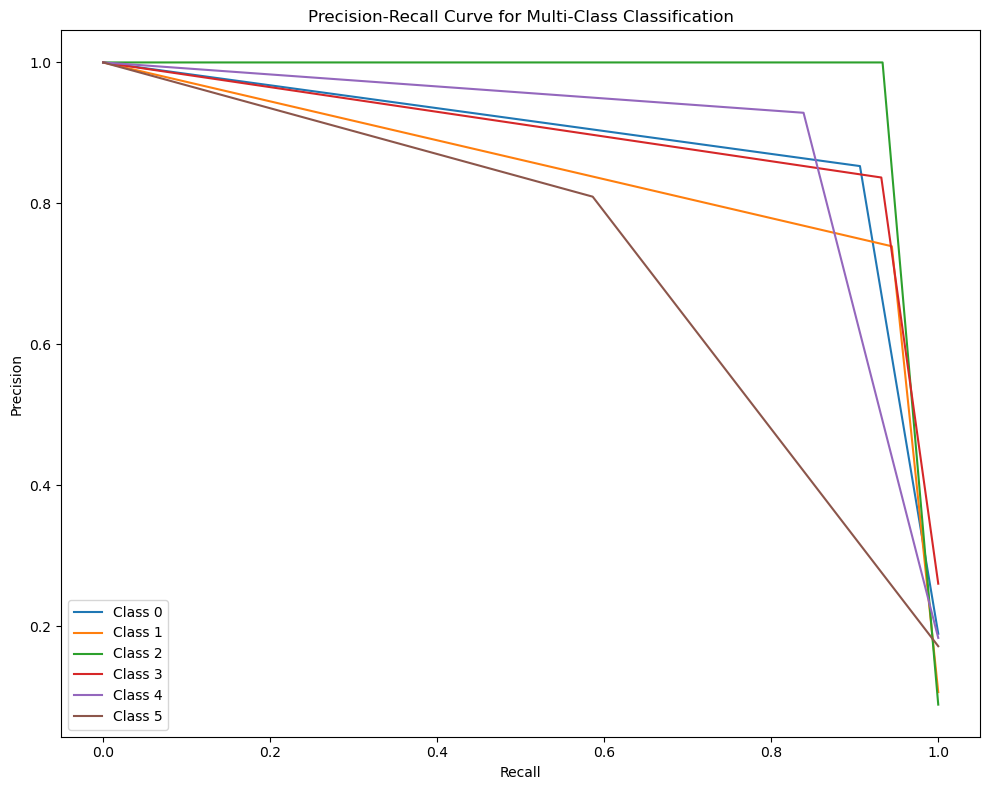

In [351]:
from sklearn.metrics import precision_recall_curve

# Compute Precision-Recall curve
precision = dict()
recall = dict()
for i in range(6):  # Adjust number of classes
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_pred_bin[:, i])

# Plot Precision-Recall curve
plt.figure(figsize=(10, 8))
for i in range(6):
    plt.plot(recall[i], precision[i], label=f'Class {i}')

plt.title('Precision-Recall Curve for Multi-Class Classification')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


# Video

In [107]:
def play_video_in_notebook(video_path):
    """
    Play a video inside a Jupyter notebook.
    
    Parameters:
        video_path (str): Path to the video file.
    """
    # Open the video file
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    while True:
        # Read the next frame from the video
        ret, frame = cap.read()

        if not ret:
            print("End of video.")
            break

        # Convert the frame from BGR to RGB (OpenCV uses BGR by default)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Display the frame using matplotlib
        plt.figure(figsize=(10, 6))
        plt.imshow(frame_rgb)
        plt.axis('off')  # Turn off the axis
        display(plt.gcf())  # Display the current frame
        
        # Clear the output to display the next frame in the same position
        clear_output(wait=True)

        # Wait a little bit to simulate video playback (adjust time for frame rate)
        plt.pause(0.03)

    cap.release()

In [35]:
video_accuracy = 0.72333

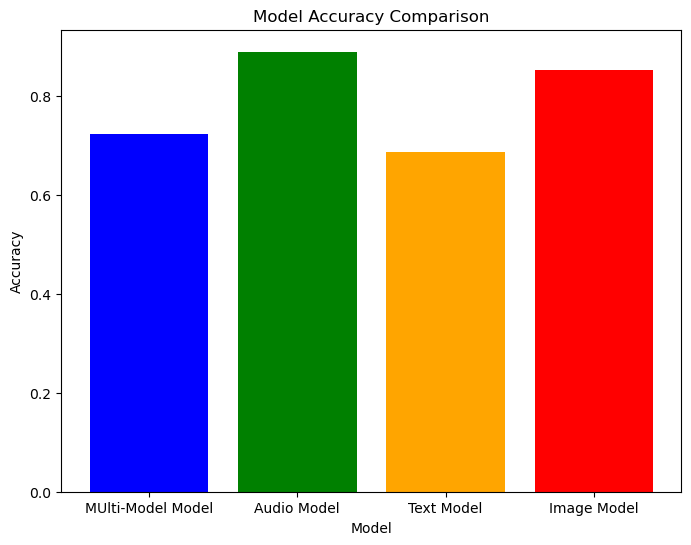

In [9]:
import matplotlib.pyplot as plt

# Accuracy values for each model
accuracy_values = {
    'MUlti-Model Model': video_accuracy,
    'Audio Model': test_accuracy_audio,
    'Text Model': text_accuracy,
    'Image Model': test_accuracy_image
}

# Plotting the accuracy values
plt.figure(figsize=(8, 6))

# Create a bar plot
plt.bar(accuracy_values.keys(), accuracy_values.values(), color=['blue', 'green', 'orange', 'red'])

# Adding title and labels
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')

# Display the plot
plt.show()
